<a href="https://colab.research.google.com/github/ayyucedemirbas/Bioinformatics/blob/main/ZINB_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

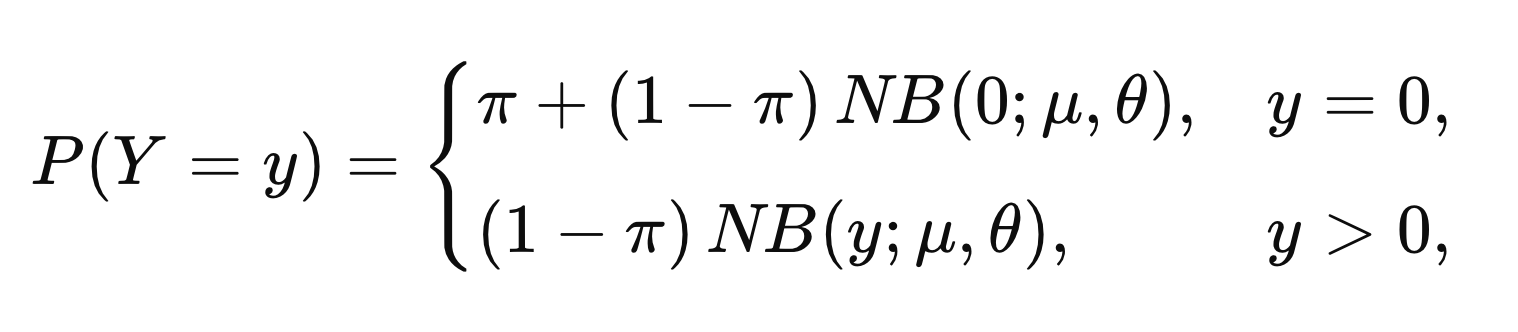

In [3]:
import torch
import torch.nn.functional as F

def zinb_loss(y_true, #tensor
              mu, #tensor
              theta, #tensor
              pi, #tensor
              eps=1e-8):

    theta = torch.clamp(theta, min=eps, max=1e4)
    mu = torch.clamp(mu, min=eps, max=1e4)
    pi = torch.clamp(pi, min=eps, max=1.0 - eps)


    # log P_NB(k) = log_gamma(k + θ) - log_gamma(k + 1) - log_gamma(θ) + θ * (log(θ) - log(θ + μ)) + k * (log(μ) - log(θ + μ))

    t1 = torch.lgamma(y_true + theta)
    t2 = torch.lgamma(y_true + 1.0)
    t3 = torch.lgamma(theta)
    t4 = theta * (torch.log(theta) - torch.log(theta + mu))
    t5 = y_true * (torch.log(mu) - torch.log(theta + mu))

    log_nb = t1 - t2 - t3 + t4 + t5


    # if y_true > 0 Log Likelihood = log(1 - π) + log_nb
    mask_nonzero = y_true > 0
    loss_nonzero = mask_nonzero * (torch.log(1.0 - pi) + log_nb)

    # if y_true = 0 Likelihood = π + (1 - π) * P_NB(0)
    # Log Likelihood = LogSumExp( log(pi), log(1-pi) + log_nb )
    mask_zero = ~mask_nonzero

    log_pi = torch.log(pi)
    log_one_minus_pi_nb = torch.log(1.0 - pi) + log_nb


    combined_zero = torch.stack([log_pi, log_one_minus_pi_nb], dim=-1)

    loss_zero = mask_zero * torch.logsumexp(combined_zero, dim=-1)

    log_likelihood = loss_nonzero + loss_zero

    return -torch.mean(log_likelihood) #tensor

In [4]:
import tensorflow as tf

def zinb_loss(y_true,
              mu,
              theta,
              pi,
              eps=1e-8 #prevents log(0)
              ):

    y_true = tf.cast(y_true, tf.float32)
    mu = tf.cast(mu, tf.float32)
    theta = tf.cast(theta, tf.float32)
    pi = tf.cast(pi, tf.float32)


    theta = tf.clip_by_value(theta, clip_value_min=eps, clip_value_max=1e4)
    mu = tf.clip_by_value(mu, clip_value_min=eps, clip_value_max=1e4)
    pi = tf.clip_by_value(pi, clip_value_min=eps, clip_value_max=1.0 - eps)


    t1 = tf.math.lgamma(y_true + theta)
    t2 = tf.math.lgamma(y_true + 1.0)
    t3 = tf.math.lgamma(theta)
    t4 = theta * (tf.math.log(theta) - tf.math.log(theta + mu))
    t5 = y_true * (tf.math.log(mu) - tf.math.log(theta + mu))

    log_nb = t1 - t2 - t3 + t4 + t5

    # if y > 0
    # log(1 - pi) + log_nb(y)
    log_nonzero = tf.math.log(1.0 - pi) + log_nb

    # if y = 0
    # π + (1-π)NB(0).
    # LogSumExp( log(π), log(1-π) + log_nb(0) )

    log_pi = tf.math.log(pi)
    log_one_minus_pi_nb = tf.math.log(1.0 - pi) + log_nb


    combined_zero_stack = tf.stack([log_pi, log_one_minus_pi_nb], axis=-1)
    log_zero = tf.math.reduce_logsumexp(combined_zero_stack, axis=-1)

    condition = tf.cast(y_true < eps, tf.bool)

    log_likelihood = tf.where(condition, log_zero, log_nonzero)

    return -tf.reduce_mean(log_likelihood)
